In [1]:
import pydicom
import matplotlib.pyplot as plt


import sigpy.plot as pl
%matplotlib notebook
from glob import glob
import numpy as np

In [2]:
def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))])
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

In [8]:
vol = get_dicom_vol('/home/srivathsa/projects/studies/gad/stanford/data/e7ec34_bdb80a/Patient_0187/Patient_0187_SubtleGad/')
print(vol.shape)

(364, 512, 512)


<IPython.core.display.Javascript object>


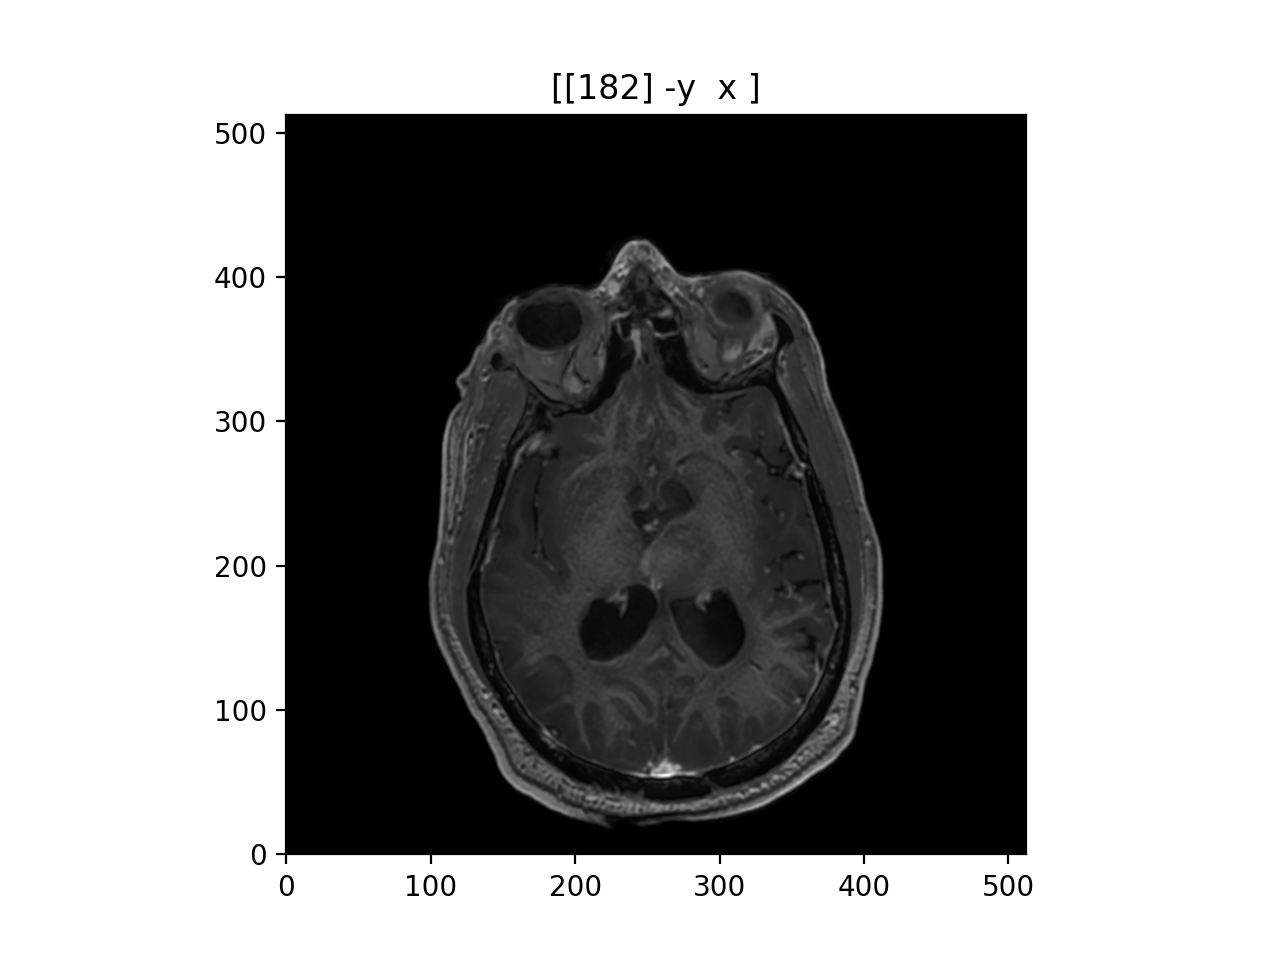

In [9]:
pl.ImagePlot(vol)

In [ ]:
y_inp = np.load('/home/srivathsa/projects/studies/gad/all/preprocess/data/NO31.npy')
print(y_inp.shape)

In [ ]:
y_pred = np.load('/home/srivathsa/projects/studies/gad/all/inference/y_pred.npy')
print(y_pred.shape)

In [ ]:
pl.ImagePlot(y_pred[..., 0])

In [ ]:
y_pred = np.load('/home/srivathsa/projects/studies/gad/all/inference/y_pred.npy')
print(y_pred.shape)
print(y_pred.dtype, y_pred.min(), y_pred.max())

In [ ]:
plt.imshow(y_pred[96, ..., 0])